In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import minimize, differential_evolution
from scipy.spatial.distance import cdist
from statsmodels.gam.api import GLMGam, BSplines
from statsmodels.genmod.families import Gamma as GammaFamily
from statsmodels.genmod.families import Binomial
from sklearn.preprocessing import StandardScaler
from numba import jit
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("./weather_data_filled_1950_2023.csv.gz", 
                compression='gzip', 
                sep=',',  
                encoding='utf-8', 
                low_memory=False)

In [16]:
data.describe()

,NUM_POSTE,LAT,LON,ALTI,RR,TNTXM,day_of_year,year
count,5.650137e+06,5.650137e+06,5.650137e+06,5.650137e+06,5.641423e+06,5.650137e+06,5.650137e+06,5.650137e+06
mean,3.309204e+07,4.742934e+01,1.699505e+00,1.450522e+02,1.956111e+00,1.139960e+01,1.831341e+02,1.989083e+03
std,9.268499e+06,5.888690e-01,7.028758e-01,6.095975e+01,4.374759e+00,6.568808e+00,1.054492e+02,2.024369e+01
min,1.800300e+07,4.642533e+01,1.078330e-01,3.100000e+01,0.000000e+00,-2.030000e+01,1.000000e+00,1.950000e+03
25%,2.807000e+07,4.697183e+01,1.178333e+00,1.070000e+02,0.000000e+00,6.600000e+00,9.200000e+01,1.973000e+03
50%,3.613900e+07,4.733617e+01,1.692333e+00,1.320000e+02,0.000000e+00,1.146893e+01,1.830000e+02,1.992000e+03
75%,4.105000e+07,4.788667e+01,2.243833e+00,1.690000e+02,1.900000e+00,1.650000e+01,2.740000e+02,2.006000e+03
max,4.534000e+07,4.880150e+01,3.053333e+00,4.620000e+02,1.808000e+02,3.280000e+01,3.660000e+02,2.023000e+03


In [17]:
data.head()

,NUM_POSTE,NOM_USUEL,LAT,LON,ALTI,RR,TNTXM,day_of_year,year,is_imputed
0,18003002,LES AIX,47.216667,2.55,182,0.0,-1.106477,1,1950,True
1,18003002,LES AIX,47.216667,2.55,182,1.6,-3.019302,2,1950,True
2,18003002,LES AIX,47.216667,2.55,182,5.4,3.601141,3,1950,True
3,18003002,LES AIX,47.216667,2.55,182,2.0,7.346058,4,1950,True
4,18003002,LES AIX,47.216667,2.55,182,1.9,7.248367,5,1950,True


#### N'utilisons que les stations du LOIRET :

In [2]:
df = pd.read_csv("./LOIRET_weather_data_filled_1950_2023.csv.gz", 
                compression='gzip', 
                sep=',',  
                encoding='utf-8', 
                low_memory=False)

In [3]:
df.count()

NUM_POSTE      843531
NOM_USUEL      843531
LAT            843531
LON            843531
ALTI           843531
RR             843125
TNTXM          843531
day_of_year    843531
year           843531
is_imputed     843531
dtype: int64

### 3.2. Marginal Modeling :

In [5]:
class MarginalPrecipitationModel:
    """
    Modèle marginal en trois étapes pour les précipitations extrêmes
    basé sur Zhong et al. (2025)
    """
    
    def __init__(self, df, threshold_prob=0.9):
        """
        Parameters:
        -----------
        df : DataFrame
            Données avec colonnes: RR, TNTXM, day_of_year, year, LAT, LON, ALTI, NUM_POSTE
        threshold_prob : float
            Probabilité de seuil pour la distribution Gamma (défaut: 0.9)
        """
        self.df = df.copy()
        self.threshold_prob = threshold_prob
        
        # Préparer les données (enlever les valeurs manquantes et extrêmes)
        self.df_valid = self.df[
            (self.df['RR'].notna()) & 
            (self.df['RR'] > 0) & 
            (self.df['RR'] < 1000)
        ].copy()
        
        # Normaliser l'altitude en km
        self.df_valid['ALTI_km'] = self.df_valid['ALTI'] / 1000
        
        # Résultats des modèles
        self.gamma_model = None
        self.binomial_model = None
        self.gpd_params = None
        
    def fit_gamma_bulk(self, k_day=10, k_spatial=10, k_alti=10):
        """
        Étape 1: Ajuster une distribution Gamma pour la masse de la distribution
        
        Modèle: RR ~ TNTXM + s(day_of_year) + te(LON, LAT) + s(ALTI)
        """
        print("Étape 1: Ajustement du modèle Gamma...")
        
        # Préparer les splines
        x_spline_day = BSplines(
            self.df_valid['day_of_year'], 
            df=[k_day], 
            degree=[3]
        )
        
        x_spline_alti = BSplines(
            self.df_valid['ALTI_km'], 
            df=[k_alti], 
            degree=[3]
        )
        
        # Pour le terme spatial te(LON, LAT), on utilise des splines tensorielle
        # Approximation avec produit de splines univariées
        x_spline_lon = BSplines(
            self.df_valid['LON'], 
            df=[k_spatial], 
            degree=[3]
        )
        
        x_spline_lat = BSplines(
            self.df_valid['LAT'], 
            df=[k_spatial], 
            degree=[3]
        )
        
        # Créer la matrice de design
        import statsmodels.api as sm
        
        # Modèle linéaire pour la température
        X_temp = sm.add_constant(self.df_valid['TNTXM'])
        
        # Combiner avec les splines
        X_full = np.column_stack([
            X_temp,
            x_spline_day.basis,
            x_spline_lon.basis,
            x_spline_lat.basis,
            x_spline_alti.basis
        ])
        
        # Ajuster le modèle Gamma avec lien log
        self.gamma_model = sm.GLM(
            self.df_valid['RR'], 
            X_full,
            family=sm.families.Gamma(link=sm.families.links.log())
        ).fit()
        
        # Prédictions
        fitted_mean = self.gamma_model.fittedvalues
        
        # Estimer les paramètres de la Gamma
        # Pour Gamma: E[Y] = shape * scale, Var[Y] = shape * scale^2
        # Donc: shape = E[Y]^2 / Var[Y], scale = Var[Y] / E[Y]
        residuals = self.df_valid['RR'] - fitted_mean
        
        # Utiliser la déviance pour estimer le paramètre de dispersion
        scale_est = self.gamma_model.scale
        shape_est = 1 / scale_est
        scale_param = fitted_mean / shape_est
        
        # Calculer les quantiles à 90%
        self.df_valid['gamma_shape'] = shape_est
        self.df_valid['gamma_scale'] = scale_param
        self.df_valid['threshold'] = stats.gamma.ppf(
            self.threshold_prob, 
            a=shape_est, 
            scale=scale_param
        )
        
        print(f"  Paramètre de forme moyen: {shape_est:.4f}")
        print(f"  Seuil moyen (90%): {self.df_valid['threshold'].mean():.2f} mm")
        
        return self.gamma_model
    
    def fit_binomial_exceedance(self, k_day=10, k_spatial=10, k_alti=10):
        """
        Étape 2: Ajuster un modèle binomial pour les dépassements de seuil
        
        Modèle: I(RR > threshold) ~ TNTXM + s(day_of_year) + te(LON, LAT) + s(ALTI)
        """
        print("\nÉtape 2: Ajustement du modèle binomial...")
        
        # Créer la variable binaire
        self.df_valid['exceeds_threshold'] = (
            self.df_valid['RR'] > self.df_valid['threshold']
        ).astype(int)
        
        # Préparer les splines (même structure que Gamma)
        x_spline_day = BSplines(
            self.df_valid['day_of_year'], 
            df=[k_day], 
            degree=[3]
        )
        
        x_spline_alti = BSplines(
            self.df_valid['ALTI_km'], 
            df=[k_alti], 
            degree=[3]
        )
        
        x_spline_lon = BSplines(
            self.df_valid['LON'], 
            df=[k_spatial], 
            degree=[3]
        )
        
        x_spline_lat = BSplines(
            self.df_valid['LAT'], 
            df=[k_spatial], 
            degree=[3]
        )
        
        import statsmodels.api as sm
        X_temp = sm.add_constant(self.df_valid['TNTXM'])
        
        X_full = np.column_stack([
            X_temp,
            x_spline_day.basis,
            x_spline_lon.basis,
            x_spline_lat.basis,
            x_spline_alti.basis
        ])
        
        # Ajuster le modèle binomial avec lien logit
        self.binomial_model = sm.GLM(
            self.df_valid['exceeds_threshold'],
            X_full,
            family=sm.families.Binomial()
        ).fit()
        
        self.df_valid['exceedance_prob'] = self.binomial_model.fittedvalues
        
        n_exceedances = self.df_valid['exceeds_threshold'].sum()
        print(f"  Nombre de dépassements: {n_exceedances}")
        print(f"  Probabilité moyenne de dépassement: {self.df_valid['exceedance_prob'].mean():.4f}")
        
        return self.binomial_model
    
    def fit_gpd_tail(self, k_day=10, k_spatial=10, k_alti=10):
        """
        Étape 3: Ajuster une distribution de Pareto généralisée (GPD) 
        pour les excès au-dessus du seuil
        
        Modèle: 
        - log(scale) ~ log(threshold) + TNTXM + s(day_of_year) + te(LON, LAT) + s(ALTI)
        - shape: constant
        """
        print("\nÉtape 3: Ajustement du modèle GPD...")
        
        # Sélectionner uniquement les excès
        df_exceedances = self.df_valid[
            self.df_valid['exceeds_threshold'] == 1
        ].copy()
        
        # Calculer les excès
        df_exceedances['excess'] = (
            df_exceedances['RR'] - df_exceedances['threshold']
        )
        
        # Vérifier qu'on a des excès positifs
        df_exceedances = df_exceedances[df_exceedances['excess'] > 1e-5].copy()
        
        print(f"  Nombre d'excès: {len(df_exceedances)}")
        
        # Préparer les covariables
        x_spline_day = BSplines(
            df_exceedances['day_of_year'], 
            df=[k_day], 
            degree=[3]
        )
        
        x_spline_alti = BSplines(
            df_exceedances['ALTI_km'], 
            df=[k_alti], 
            degree=[3]
        )
        
        x_spline_lon = BSplines(
            df_exceedances['LON'], 
            df=[k_spatial], 
            degree=[3]
        )
        
        x_spline_lat = BSplines(
            df_exceedances['LAT'], 
            df=[k_spatial], 
            degree=[3]
        )
        
        import statsmodels.api as sm
        
        # Inclure log(threshold) comme offset/variable
        X_predictors = np.column_stack([
            np.ones(len(df_exceedances)),  # Intercept
            np.log(df_exceedances['threshold']),
            df_exceedances['TNTXM'],
            x_spline_day.basis[:, 1:],
            x_spline_lon.basis[:, 1:],
            x_spline_lat.basis[:, 1:],
            x_spline_alti.basis[:, 1:]
        ])
        
        scaler = StandardScaler()
        X_predictors[:, 1:] = scaler.fit_transform(X_predictors[:, 1:])

        cond_number = np.linalg.cond(X_predictors)
        print(f"Condition number de la matrice X: {cond_number:.2e}")
        if cond_number > 1e10:
            print("ATTENTION: Matrice mal conditionnée (colinéarité). L'optimisation va échouer.")

        # Pour la GPD, on utilise une approche de maximum de vraisemblance
        # On modélise log(scale) avec GLM Gamma
        
        def gpd_neg_loglik(params, y, X):
            """Negative log-likelihood for GPD"""
            n_beta = X.shape[1]
            beta = params[:n_beta]
            xi = params[n_beta]  # shape parameter
            
            log_scale = X @ beta
            scale = np.exp(log_scale)
            
            # GPD log-likelihood
            if abs(xi) < 1e-5:
            # Cas exponentiel (limite xi -> 0)
                ll = -np.sum(np.log(scale)) - np.sum(y / scale)
            else:
                z = 1 + xi * y / scale
                if np.any(z <= 0):
                    return 1e12
            
            # Log-vraisemblance standard
            ll = -np.sum(np.log(scale)) - (1/xi + 1) * np.sum(np.log(z))

            return -ll
        
        # Initialisation
        initial_beta = np.zeros(X_predictors.shape[1])
        initial_beta[0] = np.log(df_exceedances['excess'].mean())
        initial_xi = 0.1
        initial_params = np.concatenate([initial_beta, [initial_xi]])
        
        bounds = [(None, None)] * X_predictors.shape[1] + [(-0.5, 0.8)]

        # Optimisation
        result = minimize(
            gpd_neg_loglik,
            initial_params,
            args=(df_exceedances['excess'].values, X_predictors),
            method='L-BFGS-B',
            bounds=bounds,
            options={'maxiter': 5000, 'xatol': 1e-4, 'fatol': 1e-4}
        )
        
        if result.success:
            beta_hat = result.x[:-1]
            xi_hat = result.x[-1]
            
            self.gpd_params = {
                'beta': beta_hat,
                'xi': xi_hat,
                'X_predictors': X_predictors
            }
            
            # Calculer les échelles ajustées
            log_scale_fitted = X_predictors @ beta_hat
            df_exceedances['gpd_scale'] = np.exp(log_scale_fitted)
            df_exceedances['gpd_shape'] = xi_hat
            
            print(f"  Paramètre de forme ξ: {xi_hat:.4f}")
            print(f"  Échelle moyenne: {df_exceedances['gpd_scale'].mean():.2f}")
            
            # Stocker les résultats
            self.df_exceedances = df_exceedances
        else:
            print("  ATTENTION: L'optimisation GPD n'a pas convergé")
            self.gpd_params = None
        
        return self.gpd_params
    
    def transform_to_uniform(self):
        """
        Transformer les données vers une échelle uniforme [0,1]
        en utilisant la transformation intégrale de probabilité.
        Version corrigée : utilise pd.Series indexée pour éviter IndexError.
        """
        print("\nTransformation vers échelle uniforme...")

        # Créer une Series indexée comme self.df_valid
        uniform_scores = pd.Series(index=self.df_valid.index, dtype=float)

        # Indices non-excédants
        non_exceed_idx = self.df_valid['exceeds_threshold'] == 0
        if non_exceed_idx.any():
            # stats.gamma.cdf peut accepter tableaux alignés
            uniform_scores.loc[non_exceed_idx] = stats.gamma.cdf(
                self.df_valid.loc[non_exceed_idx, 'RR'].values,
                a=self.df_valid.loc[non_exceed_idx, 'gamma_shape'].values,
                scale=self.df_valid.loc[non_exceed_idx, 'gamma_scale'].values
            )

        # Pour les excédants (si GPD ajusté)
        if self.gpd_params is not None and hasattr(self, 'df_exceedances'):
            exceed_idx = self.df_valid['exceeds_threshold'] == 1
            if exceed_idx.any():
                # Probabilité d'excéder le seuil pour ces observations
                exceed_prob = self.df_valid.loc[exceed_idx, 'exceedance_prob']

                # On utilise df_exceedances (index commun) pour récupérer scale et xi
                # itération sur df_exceedances est sûre car ses index appartiennent à self.df_valid.index
                for orig_idx, row_exc in self.df_exceedances.iterrows():
                    # excess = observed - threshold (déjà calculé dans df_exceedances)
                    excess = row_exc['excess']
                    scale = row_exc['gpd_scale']
                    xi = row_exc['gpd_shape']

                    # CDF de la GPD conditionnelle P(Y <= y | Y > u)
                    if abs(xi) < 1e-6:
                        p_excess = 1 - np.exp(-excess / scale)
                    else:
                        z = 1 + xi * excess / scale
                        if z > 0:
                            p_excess = 1 - z ** (-1.0 / xi)
                        else:
                            p_excess = 1.0

                    # Probabilité totale: P(Y <= y) = (1 - p_u) + p_u * P_cond
                    pu = exceed_prob.loc[orig_idx]
                    uniform_scores.loc[orig_idx] = (1.0 - pu) + pu * p_excess

        # Remplir les éventuels NaN restants à sécurité (par ex. si aucune catégorie)
        uniform_scores = uniform_scores.fillna(0.0)

        # Empêcher la valeur exactement égale à 1.0
        self.df_valid['uniform_score'] = (uniform_scores / (1.0 + 1e-10)).astype(float)

        print(f"  Scores uniformes calculés pour {self.df_valid['uniform_score'].notna().sum()} observations")

        return self.df_valid['uniform_score']

    
    def transform_to_unit_pareto(self):
        """
        Transformer vers échelle Pareto unitaire pour l'analyse de dépendance
        """
        if 'uniform_score' not in self.df_valid.columns:
            self.transform_to_uniform()
        
        # Transformation: Y_pareto = 1 / (1 - U)
        # où U ~ Uniform(0,1)
        unit_pareto = 1 / (1 - self.df_valid['uniform_score'])
        self.df_valid['unit_pareto'] = unit_pareto
        
        print(f"\nTransformation Pareto unitaire:")
        print(f"  Min: {unit_pareto.min():.2f}")
        print(f"  Max: {unit_pareto.max():.2f}")
        print(f"  Médiane: {unit_pareto.median():.2f}")
        
        return unit_pareto
    
    def fit_complete_model(self):
        """
        Ajuster le modèle complet en trois étapes
        """
        self.fit_gamma_bulk()
        self.fit_binomial_exceedance()
        self.fit_gpd_tail()
        self.transform_to_uniform()
        self.transform_to_unit_pareto()
        
        return self
    
    def get_results_summary(self):
        """
        Obtenir un résumé des résultats
        """
        summary = {
            'n_observations': len(self.df_valid),
            'n_exceedances': self.df_valid['exceeds_threshold'].sum(),
            'threshold_90pct': self.df_valid['threshold'].mean(),
            'gamma_shape': self.df_valid['gamma_shape'].mean(),
            'exceedance_prob': self.df_valid['exceedance_prob'].mean(),
        }
        
        if self.gpd_params is not None:
            summary['gpd_shape'] = self.gpd_params['xi']
            summary['gpd_scale_mean'] = self.df_exceedances['gpd_scale'].mean()
        
        return summary

In [6]:
# Exemple d'utilisation
if __name__ == "__main__":
    model = MarginalPrecipitationModel(df, threshold_prob=0.9)
    model.fit_complete_model()
    
    # Obtenir les résultats
    summary = model.get_results_summary()
    print("\nRésumé des résultats:")
    for key, value in summary.items():
         print(f"  {key}: {value}")
    
    # Les données transformées sont dans model.df_valid
    # avec les colonnes 'uniform_score' et 'unit_pareto'
    
    pass

Étape 1: Ajustement du modèle Gamma...
  Paramètre de forme moyen: 0.6651
  Seuil moyen (90%): 10.80 mm

Étape 2: Ajustement du modèle binomial...
  Nombre de dépassements: 36520
  Probabilité moyenne de dépassement: 0.0968

Étape 3: Ajustement du modèle GPD...
  Nombre d'excès: 36520
Condition number de la matrice X: 4.70e+01
  Paramètre de forme ξ: 0.0484
  Échelle moyenne: 5.63

Transformation vers échelle uniforme...
  Scores uniformes calculés pour 377234 observations

Transformation Pareto unitaire:
  Min: 1.05
  Max: 518991.74
  Médiane: 2.01

Résumé des résultats:
  n_observations: 377234
  n_exceedances: 36520
  threshold_90pct: 10.804605893985677
  gamma_shape: 0.6651143418256771
  exceedance_prob: 0.0968099375984173
  gpd_shape: 0.04837380882601903
  gpd_scale_mean: 5.634735759094557


In [7]:
model.df_valid.columns

Index(['NUM_POSTE', 'NOM_USUEL', 'LAT', 'LON', 'ALTI', 'RR', 'TNTXM',
       'day_of_year', 'year', 'is_imputed', 'ALTI_km', 'gamma_shape',
       'gamma_scale', 'threshold', 'exceeds_threshold', 'exceedance_prob',
       'uniform_score', 'unit_pareto'],
      dtype='object')

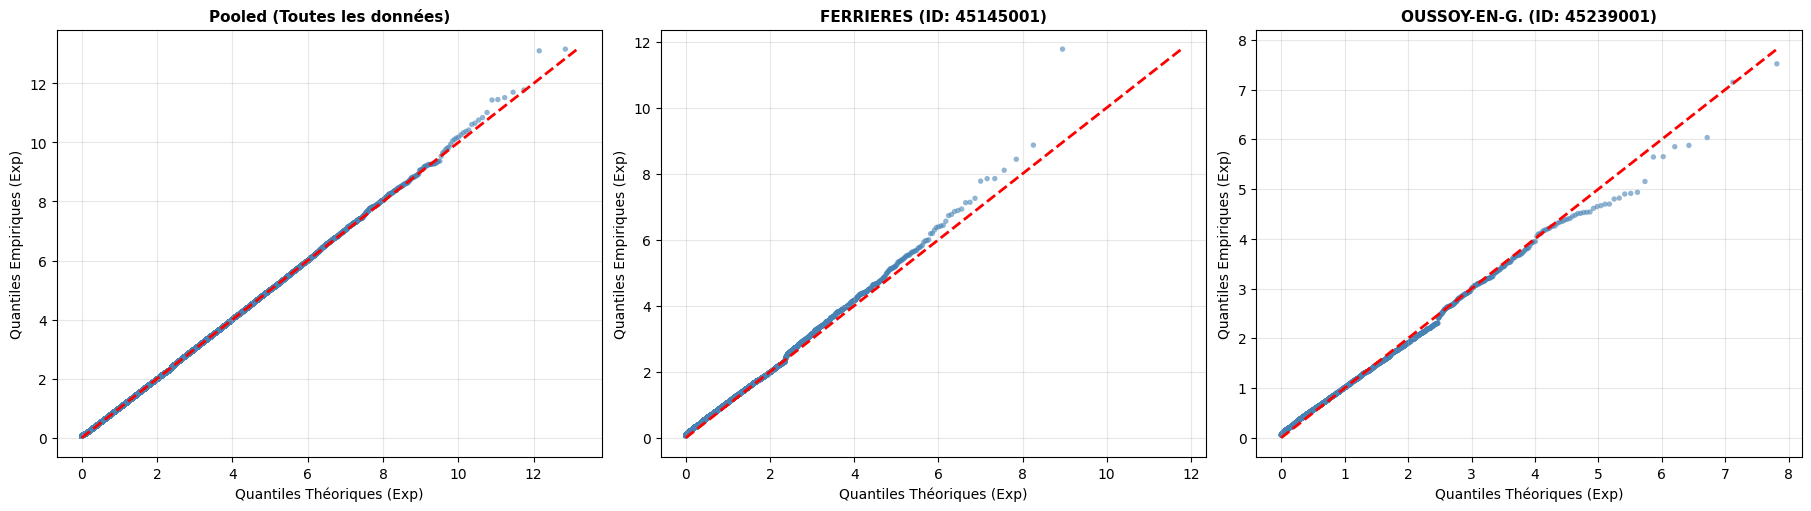

In [8]:
def plot_qq_exponential(ax, df_subset, title):
    """Génère un QQ-plot en échelle Exponentielle Standard."""
    # 1. Préparation : On transforme le score uniforme u -> exp standard
    # e = -ln(1 - u)
    u = df_subset['uniform_score'].dropna().values
    
    # Clip pour éviter log(0)
    u = np.clip(u, 0, 1 - 1e-9)
    
    # 2. Calculs
    empirique = np.sort(-np.log(1 - u))
    n = len(empirique)
    
    # Plotting positions : k / (n+1)
    theorique = -np.log(1 - np.arange(1, n + 1) / (n + 1))
    
    # 3. Plot
    ax.scatter(theorique, empirique, c='steelblue', s=15, alpha=0.6, edgecolors='none')
    
    # Ligne d'identité (y=x)
    max_val = max(theorique.max(), empirique.max())
    ax.plot([0, max_val], [0, max_val], 'r--', lw=2, label='Idéal')
    
    # Labels
    ax.set_title(title, fontsize=11, fontweight='bold')
    ax.set_xlabel("Quantiles Théoriques (Exp)")
    ax.set_ylabel("Quantiles Empiriques (Exp)")
    ax.grid(True, alpha=0.3)

# --- Exécution ---

# Configuration de la figure
fig, axes = plt.subplots(1, 3, figsize=(18, 5), constrained_layout=True)

# 1. Pooled (Global)
plot_qq_exponential(axes[0], model.df_valid, "Pooled (Toutes les données)")

# 2. Sélection de 2 stations aléatoires
all_stations = model.df_valid['NUM_POSTE'].unique()
selected_stations = np.random.choice(all_stations, 2, replace=False)

# 3. Boucle sur les 2 stations
for i, station_id in enumerate(selected_stations, 1):
    df_st = model.df_valid[model.df_valid['NUM_POSTE'] == station_id]
    nom_st = df_st['NOM_USUEL'].iloc[0]
    
    plot_qq_exponential(axes[i], df_st, f"{nom_st} (ID: {station_id})")

plt.show()

### A faire :

Figure 6. Estimated seasonal average (nonstationary) return level for the exceedance probability q = 1/(100 × 91) for each season (in colors) and each region (panels)
based on temperature observations from ERA5-Land (dotted, 1965–2020) or averaged predictions from three CMIP6 Climate models under SSP 2-4.5 (dashed) and SSP 5-8.5
(solid, 2015–2100) at locations with the smallest number of missing values

In [13]:
model.df_valid.to_csv('LOIRET_marginal_model_data.csv.gz', index=False, compression='gzip')

### 3.3 Dependance Modeling

In [3]:
df_valid = pd.read_csv("./LOIRET_marginal_model_data.csv.gz", 
                compression='gzip', 
                sep=',',  
                encoding='utf-8', 
                low_memory=False)

In [46]:
@jit(nopython=True)
def compute_gamma_matrix(dist_matrix, nu, range_param):
    """Version optimisée JIT du calcul de semi-variogramme"""
    n = dist_matrix.shape[0]
    gamma = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            gamma[i, j] = (dist_matrix[i, j] / range_param) ** nu
    return gamma + 1e-6 * np.eye(n)

class SpatialDependenceModel:
    """
    Modèle de dépendance spatiale optimisé
    Basé sur Zhong et al. (2025) - Section 3.3
    """
    
    def __init__(self, df_valid, theta=1, subsample_events=None):
        """
        Parameters:
        -----------
        df_valid : DataFrame
            Données transformées
        theta : float
            Paramètre du risk functional (défaut: 1)
        subsample_events : int, optional
            Sous-échantillonner les événements pour accélérer
        """
        self.df_valid = df_valid.copy()
        self.theta = theta
        self.subsample_events = subsample_events
        
        # Préparer les coordonnées spatiales
        self.stations = df_valid[['NUM_POSTE', 'LAT', 'LON']].drop_duplicates()
        self.n_stations = len(self.stations)
        
        # Matrice de distances entre stations (en km)
        self.coords = self.stations[['LON', 'LAT']].values
        self.dist_matrix = self._compute_distances()
        
        print(f"Initialisation du modèle de dépendance spatiale:")
        print(f"  Nombre de stations: {self.n_stations}")
        print(f"  Risk functional theta: {self.theta}")
        print(f"  Distance max: {self.dist_matrix.max():.1f} km")
    
    def _compute_distances(self):
        """Calcul optimisé des distances avec vectorisation"""
        coords_rad = np.radians(self.coords)
        
        # Formule de Haversine vectorisée
        lat1 = coords_rad[:, 1:2]
        lon1 = coords_rad[:, 0:1]
        lat2 = coords_rad[:, 1:2].T
        lon2 = coords_rad[:, 0:1].T
        
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        
        a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
        c = 2 * np.arcsin(np.sqrt(np.clip(a, 0, 1)))
        
        return 6371 * c  # Rayon Terre en km
    
    def _semivariogram(self, h, params):
        """Semi-variogramme: γ(h) = (h / exp(λ0))^ν"""
        nu, lambda0, _ = params
        range_param = np.exp(lambda0)
        return (h / range_param) ** nu
    
    def _semivariogram_temporal(self, h, params, temp):
        """Semi-variogramme avec variation temporelle"""
        nu, lambda0, lambda1 = params
        range_param = np.exp(lambda0 + lambda1 * temp)
        return (h / range_param) ** nu
    
    def _compute_risk_functional(self, data_matrix):
        """Calculer r_theta de façon vectorisée"""
        data_clean = np.nan_to_num(data_matrix, nan=0.0)
        
        if self.theta == 1:
            return np.mean(data_clean, axis=1)
        else:
            return np.power(np.mean(np.power(data_clean, self.theta), axis=1), 1/self.theta)
    
    def select_exceedances(self, threshold_quantile=0.9, min_obs=10):
        """Sélection optimisée des excès"""
        print(f"\nSélection des excès spatiaux...")
        
        # Pivot optimisé
        pivot_data = self.df_valid.pivot_table(
            values='unit_pareto',
            index=['year', 'day_of_year'],
            columns='NUM_POSTE',
            aggfunc='first'
        )
        
        # Filtrer événements valides
        n_obs = (~pivot_data.isna()).sum(axis=1)
        valid_events = n_obs >= min_obs
        pivot_data_valid = pivot_data[valid_events]
        
        print(f"  Événements avec ≥{min_obs} obs: {valid_events.sum()}")
        
        # Risk functional
        r_values = self._compute_risk_functional(pivot_data_valid.values)
        threshold = np.quantile(r_values, threshold_quantile)
        exceeds = r_values > threshold
        
        self.exceedances_idx = pivot_data_valid.index[exceeds]
        self.exceedances_data = pivot_data_valid[exceeds]
        self.threshold = threshold
        
        # Sous-échantillonnage si demandé
        if self.subsample_events and len(self.exceedances_data) > self.subsample_events:
            sample_idx = np.random.choice(
                len(self.exceedances_data), 
                self.subsample_events, 
                replace=False
            )
            self.exceedances_idx = self.exceedances_idx[sample_idx]
            self.exceedances_data = self.exceedances_data.iloc[sample_idx]
            print(f"  Sous-échantillonnage: {len(self.exceedances_data)} événements")
        
        self.n_exceedances = len(self.exceedances_data)
        print(f"  Seuil r: {threshold:.3f}")
        print(f"  Nombre d'excès: {self.n_exceedances}")
        
        # Températures moyennes par événement
        temp_data = []
        for year, doy in self.exceedances_idx:
            temp_vals = self.df_valid[
                (self.df_valid['year'] == year) & 
                (self.df_valid['day_of_year'] == doy)
            ]['TNTXM']
            temp_data.append(temp_vals.mean())
        
        self.exceedances_temp = np.array(temp_data)
        
        # Pré-calculer les indices valides pour chaque événement
        self._precompute_valid_indices()
        
        return self.exceedances_data
    
    def _precompute_valid_indices(self):
        """Pré-calculer les masques et distances pour accélérer"""
        self.valid_masks = []
        self.valid_distances = []
        self.valid_y = []
        
        for _, row in self.exceedances_data.iterrows():
            y = row.values
            valid = ~np.isnan(y)
            
            if valid.sum() >= 2:
                valid_idx = np.where(valid)[0]
                dist_sub = self.dist_matrix[np.ix_(valid_idx, valid_idx)]
                
                self.valid_masks.append(valid)
                self.valid_distances.append(dist_sub)
                self.valid_y.append(y[valid])
            else:
                self.valid_masks.append(None)
                self.valid_distances.append(None)
                self.valid_y.append(None)
    
    def _gradient_score_fast(self, params, use_temperature=True):
        """Version ultra-optimisée du gradient score"""
        nu, lambda0, lambda1 = params
        
        # Contraintes strictes
        if nu <= 0.1 or nu > 2 or np.abs(lambda0) > 10 or np.abs(lambda1) > 1:
            return 1e10
        
        score = 0
        n_valid = 0
        
        for i in range(len(self.valid_y)):
            if self.valid_y[i] is None:
                continue
            
            y_valid = self.valid_y[i]
            dist_sub = self.valid_distances[i]
            n = len(y_valid)
            
            # Semi-variogramme
            if use_temperature:
                temp = self.exceedances_temp[i]
                range_param = np.exp(lambda0 + lambda1 * temp)
            else:
                range_param = np.exp(lambda0)
            
            gamma_matrix = compute_gamma_matrix(dist_sub, nu, range_param)
            
            try:
                # Inverse (avec gestion d'erreur)
                gamma_inv = np.linalg.inv(gamma_matrix)
                
                # Calculs simplifiés
                q = gamma_inv.sum(axis=1)
                q_sum = q.sum()
                
                if q_sum < 1e-10:
                    continue
                
                A = gamma_inv - np.outer(q, q) / q_sum
                
                # Gradient simplifié
                log_y = np.log(np.maximum(y_valid, 1e-10))
                gradient = -0.5 * (A @ log_y) / y_valid
                
                # Poids simplifiés
                y_mean = y_valid.mean()
                weights = y_valid * (1 - np.exp(-(y_mean - 1)))
                
                # Score
                event_score = np.sum(weights * gradient)
                score += event_score
                n_valid += 1
                
            except (np.linalg.LinAlgError, ValueError):
                continue
        
        if n_valid == 0:
            return 1e10
        
        return -score / n_valid  # Minimiser = maximiser score
    
    def fit(self, use_temperature=True):
        """
        Ajustement optimisé
        
        Parameters:
        -----------
        use_temperature : bool
            Inclure variation temporelle
        method : str
            'full': gradient score complet
        """
        
        init_params = [1.0, np.log(100), 0.0]
        
        result = minimize(
            self._gradient_score_fast,
            init_params,
            args=(use_temperature,),
            method='Nelder-Mead',
            options={'maxiter': 500, 'disp': True}
        )
        
        if result.success:
            nu_hat, lambda0_hat, lambda1_hat = result.x
            
            self.params = {
                'nu': nu_hat,
                'lambda0': lambda0_hat,
                'lambda1': lambda1_hat,
                'range_km': np.exp(lambda0_hat),
                'convergence': result.success,
                'nfev': result.nfev,
                'method': 'full'
            }
            
            print(f"  ✓ Optimisation réussie")
            print(f"  ν: {nu_hat:.4f}")
            print(f"  λ0: {lambda0_hat:.4f} → {np.exp(lambda0_hat):.1f} km")
            print(f"  λ1: {lambda1_hat:.4f}")
        else:
            print(f"  ✗ Échec: {result.message}")
            self.params = None
        
        return self.params
    
    def compute_tail_dependence_range(self, temp_values=None):
        """Calculer la portée de dépendance de queue"""
        if self.params is None:
            raise ValueError("Modèle non ajusté")
        
        nu = self.params['nu']
        lambda0 = self.params['lambda0']
        lambda1 = self.params['lambda1']
        
        if temp_values is None:
            temp_values = np.array([self.exceedances_temp.mean()])
        
        target_gamma = 2 * stats.norm.ppf(0.975)**2
        
        ranges = []
        for temp in temp_values:
            range_param = np.exp(lambda0 + lambda1 * temp)
            h = range_param * (target_gamma ** (1/nu))
            ranges.append(h)
        
        return np.array(ranges)
    
    def predict_future_ranges(self, future_temps):
        """Prédictions futures"""
        ranges = self.compute_tail_dependence_range(future_temps)
        
        return pd.DataFrame({
            'temperature': future_temps,
            'tail_dependence_range_km': ranges
        })
    
    def get_summary(self):
        """Résumé des résultats"""
        if self.params is None:
            return "Modèle non ajusté"
        
        summary = {
            'n_stations': self.n_stations,
            'n_exceedances': self.n_exceedances,
            'threshold': self.threshold,
            'nu': self.params['nu'],
            'lambda0': self.params['lambda0'],
            'lambda1': self.params['lambda1'],
            'baseline_range_km': self.params['range_km'],
            'temp_mean': self.exceedances_temp.mean(),
            'temp_std': self.exceedances_temp.std(),
            'method': self.params.get('method', 'unknown')
        }
        
        current_range = self.compute_tail_dependence_range(
            np.array([self.exceedances_temp.mean()])
        )[0]
        summary['current_tail_dep_range_km'] = current_range
        
        return summary

In [50]:
# Estimation du modèle
dep_model = SpatialDependenceModel(
    df_valid, 
    theta=1, 
    subsample_events=10000  # Limiter événements
)

dep_model.select_exceedances(threshold_quantile=0.9)

params = dep_model.fit(use_temperature=True)

Initialisation du modèle de dépendance spatiale:
  Nombre de stations: 70
  Risk functional theta: 1
  Distance max: 105.8 km

Sélection des excès spatiaux...
  Événements avec ≥10 obs: 12963
  Seuil r: 4.973
  Nombre d'excès: 1297
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 35
         Function evaluations: 85
  ✓ Optimisation réussie
  ν: 0.9974
  λ0: 4.8649 → 129.7 km
  λ1: 0.0000


In [51]:
# Résumé des résultats
summary = dep_model.get_summary()
print("\nRésumé:")
for key, val in summary.items():
    print(f"  {key}: {val}")


Résumé:
  n_stations: 70
  n_exceedances: 1297
  threshold: 4.973151685858876
  nu: 0.9973807908713086
  lambda0: 4.86485081230872
  lambda1: 1.2753061663660526e-05
  baseline_range_km: 129.65159474682062
  temp_mean: 11.08159920244522
  temp_std: 5.678527667649186
  method: full
  current_tail_dep_range_km: 1001.592090486979


In [49]:
# Calculer la portée de dépendance actuelle
current_temp = summary['temp_mean']
current_range = dep_model.compute_tail_dependence_range([current_temp])[0]
print(f"\nPortée de dépendance actuelle: {current_range:.4f} km")


Portée de dépendance actuelle: 1001.5921 km


In [52]:
# Prédictions pour températures futures
future_temps = np.linspace(current_temp, current_temp + 3, 10)
predictions = dep_model.predict_future_ranges(future_temps)
print("\nÉvolution avec le réchauffement:")
print(predictions)


Évolution avec le réchauffement:
   temperature  tail_dependence_range_km
0    11.081599               1001.592090
1    11.414933               1001.596348
2    11.748266               1001.600606
3    12.081599               1001.604864
4    12.414933               1001.609122
5    12.748266               1001.613380
6    13.081599               1001.617638
7    13.414933               1001.621895
8    13.748266               1001.626153
9    14.081599               1001.630411
